
![nufold.png](https://github.com/kiharalab/nufold/blob/master/nufold/NuFoldLogo.png?raw=1)</center>

NuFold is a state-of-the-art method designed for predicting 3D RNA structures, leveraging deep learning for high accuracy and reliability. This tool is particularly useful for biologists and bioinformatics researchers focusing on RNA function and structure.

License: GPL v3 for academic use. (For commercial use, please contact us for different licensing) Contact: Daisuke Kihara (dkihara@purdue.edu)

Cite: [Kagaya, Y., Zhang, Z., Ibtehaz, N. et al. NuFold: end-to-end approach for RNA tertiary structure prediction with flexible nucleobase center representation. Nat Commun 16, 881 (2025).](https://doi.org/10.1038/s41467-025-56261-7)


# HOW TO USE NUFOLD
- Below you will find a place to input your sequence and job name.
- After giving sequence, go to the toolbar above, click `Runtime` and then `Run all`.
- Change any settings you want to change before running.
- **UPDATE:** We added AlphaFold3's MSA pipeline. You can also choose the databases to search!

In [3]:
# @title Input your RNA sequence and provide a job name (optional)
# @markdown # Add your data here
import random
import string
import os
import re
from tqdm.notebook import tqdm


def random_string(length=10):
    """Generate a random string of fixed length."""
    letters = string.ascii_lowercase
    return "".join(random.choice(letters) for i in range(length))


rna_sequence = "GGAGAGUAGAUGAUUCGCGUUAAGUGUGUGUGAAUGGGAUGUCGUCACACAACGAAGCGAGAGCGCGGUGAAUCAUUGCAUCCGCUCCA"  # @param {type: "string"}
length = len(rna_sequence)
print(f"RNA sequence length: {length}")
rna_sequence = rna_sequence.upper()
job_name = "4LVW"  # @param {type: "string"}

if not job_name:
    job_name = random_string()

# Prepare the FASTA content
fasta_content = f">{job_name}\n{rna_sequence}"
jobs_dir = "jobs"
if not os.path.exists(jobs_dir):
    os.makedirs(jobs_dir)
job_base_dir = os.path.join(jobs_dir, f"{job_name}_base")
if not os.path.exists(job_base_dir):
    os.makedirs(job_base_dir)
actual_job_dir = os.path.join(job_base_dir, job_name)
if not os.path.exists(actual_job_dir):
    os.makedirs(actual_job_dir)
fasta_filename = f"{job_name}.fasta"
fasta_filepath = os.path.join(actual_job_dir, fasta_filename)
with open(fasta_filepath, "w") as fasta_file:
    fasta_file.write(fasta_content)

print(f"RNA sequence saved as {fasta_filepath} of length: {length}")

# @markdown If you want to download NuFold's output to your computer automatically, you can check this box here. Otherwise after the run is complete you can go to `/nufold_output` on the file explorer on the left side and download the folder with your job name.
download = True  # @param {type:"boolean"}

# @markdown ## MSA Pipeline Selection
# @markdown You can choose which MSA pipeline to use, the options are:
# @markdown - rMSA light (Without NT search)
# @markdown - AlphaFold3 MSA Pipeline (nhmmer)

# @markdown **NOTE: The free version of Google colab does not enough have enough space to install both rMSA and AlphaFold3 MSA pipelines, if you want to switch pipeline, change the pipeline and then do `Runtime` -> `Restart session and run all`**
msa_pipeline = "AlphaFold3"  # @param ["rMSA", "AlphaFold3"] {type:"string"}
print(f"Selected MSA pipeline: {msa_pipeline}")

# @markdown ## Additional Settings:
num_recycles = 3  # @param {type:"number"}

# @markdown ### rMSA Settings (if using rMSA pipeline):
msa_speed = 1  # @param {type:"slider", min:0, max:2, step:1}
# @markdown - 0 for slowest, 1 for normal, 2 for fast (Faster = Lower Quality)

# @markdown ### AlphaFold3 MSA Settings (if using AlphaFold3 pipeline):
# @markdown **NOTE: We let users choose what databases will be searched for the MSA, however with the free plan of Google colab, there is not enough disk space for the `ntrna` database. Please uncheck `use_ntrna_db` if you are using the free plan.**
# @markdown - If you have Google colab pro you do not need to worry about this
use_rfam_db = True  # @param {type:"boolean"}
use_rnacentral_db = True  # @param {type:"boolean"}
use_ntrna_db = False  # @param {type:"boolean"}
max_sequences_per_db = 10000  # @param {type:"number"}
e_value = 0.001  # @param {type:"number"}
time_limit_minutes = 120  # @param {type:"slider", min:1, max:120, step:1}

import multiprocessing

cores = multiprocessing.cpu_count()
print(f"Detected {cores} cores")
# Create a dictionary of AF3 MSA database settings for later use
af3_database_settings = {
    "Rfam": use_rfam_db,
    "RNAcentral": use_rnacentral_db,
    "NT_RNA": use_ntrna_db,
    "time_limit_minutes": time_limit_minutes,
    "max_sequences_per_db": max_sequences_per_db,
    "e_value": e_value,
    "n_cpu": 2,  # Default to 2 cores for Colab
}

RNA sequence length: 89
RNA sequence saved as jobs/4LVW_base/4LVW/4LVW.fasta of length: 89
Selected MSA pipeline: AlphaFold3
Detected 8 cores


In [4]:
# @title Installing Dependencies and setup (This can take up to 20 mins if using rMSA)
import os
import subprocess


!rm -rf sample_data


def run_command(command, log_file, message=None):
    with open(log_file, "a") as file:
        subprocess.run(command, shell=True, stdout=file, stderr=subprocess.STDOUT)
    if message:
        print(message)


logs_file = "logs.txt"
open(logs_file, "w").close()

# Check and Install rMSA if not exists
if msa_pipeline == "rMSA":
    if not os.path.exists("rMSA"):
        run_command(
            "apt-get install aria2 && "
            "git clone https://github.com/pylelab/rMSA && "
            "cd rMSA/database/ && "
            "aria2c -q -R -x 16 -j 20 -s 65536 -c --optimize-concurrent-downloads https://kiharalab.org/nufold/database.zip && "
            "unzip database.zip && "
            "rm database.zip && "
            "cd ../../",
            logs_file,
            "rMSA installation complete.",
        )
    else:
        print("rMSA directory already exists. Skipping installation.")

# Install AlphaFold3 MSA pipeline dependencies
if msa_pipeline == "AlphaFold3":
    run_command(
        "apt-get update && "
        "apt-get install -y hmmer zstd && "
        "pip install biopython tqdm numpy absl-py",
        logs_file,
        "AlphaFold3 MSA pipeline dependencies installed.",
    )

# Install libraries
run_command(
    "pip install ml-collections dm-tree deepspeed protobuf scipy biopython py3dmol",
    logs_file,
    "Libraries installation complete.",
)

# Check and Install ipknot if not exists
if not os.path.exists("/content/ipknot"):
    run_command(
        "wget https://github.com/satoken/ipknot/releases/download/v1.1.0/ipknot-1.1.0-x86_64-linux.zip && "
        "unzip ipknot-1.1.0-x86_64-linux.zip && "
        "rm ipknot-1.1.0-x86_64-linux/README.md && "
        "mv ipknot-1.1.0-x86_64-linux/ipknot /content && "
        "rmdir ipknot-1.1.0-x86_64-linux && "
        "rm ipknot-1.1.0-x86_64-linux.zip && "
        "chmod +x /content/ipknot",
        logs_file,
        "ipknot installation complete.",
    )
else:
    print("ipknot already exists. Skipping installation.")

# Check and Setup NuFold if not exists
# Make sure to add gitclone nufold here.
if not os.path.exists("/content/run_nufold.py"):
    run_command(
        "git clone https://github.com/kiharalab/NuFold &&"
        "mv /content/NuFold/nufold /content && "
        "mv /content/NuFold/run_nufold.py /content && "
        "rm -rf /content/NuFold",
        logs_file,
        "NuFold setup complete.",
    )
else:
    print("NuFold is already set up. Skipping installation.")

print("All installations and setups are complete. Check logs.txt for details.")

AlphaFold3 MSA pipeline dependencies installed.
Libraries installation complete.
ipknot installation complete.
NuFold setup complete.
All installations and setups are complete. Check logs.txt for details.


In [5]:
# @title Data Preprocess: Compute pseudoknots and perform MSA
# @markdown This step is going to take a while, allow some time for this step (keep the page open)

# Paths
jobs_dir = "jobs"
job_dir = os.path.join(jobs_dir, job_name)
fasta_filepath = os.path.join(job_dir, fasta_filename)
ss_output_path = os.path.join(job_dir, f"{job_name}.ss")

# Change to the job directory and run ipknot
%cd {actual_job_dir}
# Run ipknot and capture output
!../../../ipknot {fasta_filename} > {fasta_filename.replace('.fasta', '')}.ipknot.ss
print("📋 iPknot secondary structure prediction saved")

%cd ../../..

# Function definitions for AlphaFold3 MSA pipeline
if msa_pipeline == "AlphaFold3":
    # Define constants
    RNA_CHAIN = "polyribonucleotide"
    SHORT_SEQUENCE_CUTOFF = 50
    DB_DIR = "/tmp/rna_databases"
    os.makedirs(DB_DIR, exist_ok=True)

    # Define database URLs
    SOURCE = "https://storage.googleapis.com/alphafold-databases/v3.0"
    RNA_DATABASE_INFO = {
        "rnacentral_active_seq_id_90_cov_80_linclust.fasta": "RNAcentral",
        "nt_rna_2023_02_23_clust_seq_id_90_cov_80_rep_seq.fasta": "NT_RNA",
        "rfam_14_9_clust_seq_id_90_cov_80_rep_seq.fasta": "Rfam",
    }

    def download_with_progress(url, dest_path):
        """Download a file with a progress bar"""
        try:
            with urllib.request.urlopen(url) as response:
                file_size = int(response.info().get("Content-Length", 0))
                desc = f"Downloading {os.path.basename(dest_path)}"
                with tqdm(
                    total=file_size, unit="B", unit_scale=True, desc=desc
                ) as pbar:
                    with open(dest_path, "wb") as out_file:
                        while True:
                            buffer = response.read(8192)
                            if not buffer:
                                break
                            out_file.write(buffer)
                            pbar.update(len(buffer))
            return True
        except Exception as e:
            print(f"❌ Error downloading {url}: {e}")
            return False

    def download_selected_databases(database_settings):
        """Download only the databases selected in the settings"""
        selected_dbs = []
        if database_settings.get("Rfam", False):
            selected_dbs.append("Rfam")
        if database_settings.get("RNAcentral", False):
            selected_dbs.append("RNAcentral")
        if database_settings.get("NT_RNA", False):
            selected_dbs.append("NT_RNA")

        if not selected_dbs:
            print("⚠️ No databases selected for download!")
            return

        # Convert selected_dbs to appropriate file names
        selected_db_files = []
        for db_file, db_key in RNA_DATABASE_INFO.items():
            if db_key in selected_dbs:
                selected_db_files.append(db_file)

        if not selected_db_files:
            print("⚠️ No databases selected for download!")
            return

        print(
            f"🌐 Downloading {len(selected_db_files)} RNA databases: {', '.join([RNA_DATABASE_INFO[db] for db in selected_db_files])}"
        )

        # Check if we already have the databases
        missing_dbs = []
        for db in selected_db_files:
            db_path = os.path.join(DB_DIR, db)
            if not os.path.exists(db_path) or os.path.getsize(db_path) == 0:
                missing_dbs.append(db)

        if not missing_dbs:
            print("✅ All selected databases already downloaded.")
            return

        # Create progress bar for overall process
        with tqdm(
            total=len(missing_dbs), desc="Overall progress", unit="db", position=0
        ) as main_pbar:
            # Download and decompress each database
            for db in missing_dbs:
                dest_path = os.path.join(DB_DIR, f"{db}.zst")
                final_path = os.path.join(DB_DIR, db)

                if os.path.exists(final_path) and os.path.getsize(final_path) > 0:
                    print(f"✅ {db} already exists, skipping.")
                    main_pbar.update(1)
                    continue

                # Download the compressed file
                print(f"📥 Downloading {db} ({RNA_DATABASE_INFO[db]})...")
                url = f"{SOURCE}/{db}.zst"
                if download_with_progress(url, dest_path):
                    # Decompress with zstd
                    print(f"📦 Decompressing {db}...")
                    try:
                        subprocess.run(
                            ["zstd", "--decompress", "-f", dest_path, "-o", final_path],
                            check=True,
                        )
                        print(f"✅ Successfully processed {db}")

                        # Remove the compressed file
                        os.remove(dest_path)
                    except Exception as e:
                        print(f"❌ Error decompressing {db}: {e}")

                main_pbar.update(1)

        # Final check to see what we have
        existing_dbs = []
        for db in selected_db_files:
            db_path = os.path.join(DB_DIR, db)
            if os.path.exists(db_path) and os.path.getsize(db_path) > 0:
                existing_dbs.append(db)

        if len(existing_dbs) == len(selected_db_files):
            print("🎉 All selected databases downloaded and ready for use.")
        else:
            print(
                f"⚠️ Downloaded {len(existing_dbs)}/{len(selected_db_files)} databases."
            )
            print(
                f"✅ Available: {', '.join([RNA_DATABASE_INFO[db] for db in existing_dbs])}"
            )
            missing = [db for db in selected_db_files if db not in existing_dbs]
            print(f"❌ Missing: {', '.join([RNA_DATABASE_INFO[db] for db in missing])}")

    def create_query_fasta_file(sequence, path, linewidth=80):
        """Creates a fasta file with the sequence"""
        with open(path, "w") as f:
            f.write(">query\n")
            i = 0
            while i < len(sequence):
                f.write(f"{sequence[i : (i + linewidth)]}\n")
                i += linewidth

    def run_command(cmd, cmd_name):
        """Run a command and handle errors"""
        import logging

        logging.info(f"Running {cmd_name}: {cmd}")
        start_time = time.time()
        try:
            completed_process = subprocess.run(
                cmd,
                check=True,
                stderr=subprocess.PIPE,
                stdout=subprocess.PIPE,
                text=True,
            )
        except subprocess.CalledProcessError as e:
            logging.error(f"{cmd_name} failed.\nstdout: {e.stdout}\nstderr: {e.stderr}")
            raise RuntimeError(
                f"{cmd_name} failed\nstdout: {e.stdout}\nstderr: {e.stderr}"
            ) from e

        end_time = time.time()
        logging.info(f"Finished {cmd_name} in {end_time - start_time:.3f} seconds")
        return completed_process

    def parse_fasta(fasta_string):
        """Parse a FASTA string into sequences and descriptions"""
        sequences = []
        descriptions = []

        lines = fasta_string.strip().split("\n")
        current_seq = ""
        current_desc = ""

        for line in lines:
            if line.startswith(">"):
                if current_seq:  # Save the previous sequence
                    sequences.append(current_seq)
                    descriptions.append(current_desc)
                current_desc = line[1:].strip()  # Remove the '>' character
                current_seq = ""
            else:
                current_seq += line.strip()

        # Add the last sequence
        if current_seq:
            sequences.append(current_seq)
            descriptions.append(current_desc)

        return sequences, descriptions

    def convert_stockholm_to_a3m(stockholm_path, max_sequences=None):
        """Convert Stockholm format MSA to A3M format"""
        with open(stockholm_path, "r") as stockholm_file:
            descriptions = {}
            sequences = {}
            reached_max_sequences = False

            # First pass: extract sequences
            for line in stockholm_file:
                reached_max_sequences = (
                    max_sequences and len(sequences) >= max_sequences
                )
                line = line.strip()
                if not line or line.startswith(("#", "//")):
                    continue
                seqname, aligned_seq = line.split(maxsplit=1)
                if seqname not in sequences:
                    if reached_max_sequences:
                        continue
                    sequences[seqname] = ""
                sequences[seqname] += aligned_seq

            if not sequences:
                return ""

            # Second pass: extract descriptions
            stockholm_file.seek(0)
            for line in stockholm_file:
                line = line.strip()
                if line[:4] == "#=GS":
                    columns = line.split(maxsplit=3)
                    seqname, feature = columns[1:3]
                    value = columns[3] if len(columns) == 4 else ""
                    if feature != "DE":
                        continue
                    if reached_max_sequences and seqname not in sequences:
                        continue
                    descriptions[seqname] = value
                    if len(descriptions) == len(sequences):
                        break

        # Convert Stockholm to A3M
        a3m_sequences = {}
        query_sequence = next(iter(sequences.values()))
        for seqname, sto_sequence in sequences.items():
            # Align sequence to gapless query (simplified version)
            a3m_seq = ""
            query_idx = 0
            for i, char in enumerate(sto_sequence):
                if query_sequence[i] == "-":
                    if char != "-":
                        a3m_seq += char.lower()  # Add as lowercase (insertion)
                else:  # Query has a residue here
                    a3m_seq += char  # Add as is (match/mismatch/deletion)
                    query_idx += 1
            a3m_sequences[seqname] = a3m_seq.replace(".", "")

        # Convert to FASTA format
        fasta_chunks = []
        for seqname, seq in a3m_sequences.items():
            fasta_chunks.append(f">{seqname} {descriptions.get(seqname, '')}")
            fasta_chunks.append(seq)

        return "\n".join(fasta_chunks) + "\n"

    class Nhmmer:
        """Python wrapper of the Nhmmer binary"""

        def __init__(
            self,
            binary_path,
            hmmalign_binary_path,
            hmmbuild_binary_path,
            database_path,
            n_cpu=8,
            e_value=1e-3,
            max_sequences=10000,
            alphabet="rna",
            time_limit_minutes=None,
        ):
            """Initialize Nhmmer wrapper"""
            self.binary_path = binary_path
            self.hmmalign_binary_path = hmmalign_binary_path
            self.hmmbuild_binary_path = hmmbuild_binary_path
            self.db_path = database_path
            self.e_value = e_value
            self.n_cpu = n_cpu
            self.max_sequences = max_sequences
            self.alphabet = alphabet
            self.time_limit_seconds = (
                time_limit_minutes * 60 if time_limit_minutes else None
            )

        def query(self, target_sequence):
            """Query the database using Nhmmer and return results in A3M format"""
            import logging
            import time
            import os
            import tempfile
            import subprocess

            logging.info(f"Querying database with sequence: {target_sequence[:20]}...")

            with tempfile.TemporaryDirectory() as query_tmp_dir:
                input_fasta_path = os.path.join(query_tmp_dir, "query.fasta")
                output_sto_path = os.path.join(query_tmp_dir, "output.sto")

                # Create query FASTA file
                create_query_fasta_file(sequence=target_sequence, path=input_fasta_path)

                # Prepare Nhmmer command
                cmd_flags = [
                    "-o",
                    "/dev/null",  # Don't pollute stdout
                    "--noali",  # Don't include the alignment in stdout
                    "--cpu",
                    str(self.n_cpu),
                    "-E",
                    str(self.e_value),
                    "-A",
                    output_sto_path,
                ]

                # Add alphabet flag
                if self.alphabet:
                    cmd_flags.extend([f"--{self.alphabet}"])

                # Special handling for short RNA sequences
                if (
                    self.alphabet == "rna"
                    and len(target_sequence) < SHORT_SEQUENCE_CUTOFF
                ):
                    cmd_flags.extend(["--F3", str(0.02)])
                else:
                    cmd_flags.extend(["--F3", str(1e-5)])

                # Add input and database paths
                cmd_flags.extend([input_fasta_path, self.db_path])

                # Setup progress monitoring
                if self.time_limit_seconds is None:
                    print(
                        f"⏳ Running Nhmmer search against {os.path.basename(self.db_path)} (no time limit)"
                    )
                else:
                    print(
                        f"⏳ Running Nhmmer search against {os.path.basename(self.db_path)} (time limit: {self.time_limit_seconds // 60} min)"
                    )

                # Create a process with timeout
                cmd = [self.binary_path, *cmd_flags]
                start_time = time.time()

                try:
                    # Use subprocess with timeout
                    process = subprocess.Popen(
                        cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
                    )

                    # Create progress bar for time monitoring
                    if self.time_limit_seconds is None:
                        # If no time limit, just wait for the process to finish
                        while process.poll() is None:
                            time.sleep(5)  # Check periodically
                            elapsed = time.time() - start_time
                            # Update progress every minute
                            if int(elapsed) % 60 == 0:
                                print(
                                    f"⏳ Search in progress... (elapsed time: {elapsed:.0f} seconds)"
                                )
                    else:
                        # If time limit is set, use a progress bar
                        with tqdm(
                            total=self.time_limit_seconds,
                            desc="Search time",
                            unit="sec",
                        ) as pbar:
                            elapsed = 0
                            while (
                                process.poll() is None
                                and elapsed < self.time_limit_seconds
                            ):
                                time.sleep(1)
                                elapsed = time.time() - start_time
                                pbar.update(1)
                                pbar.set_description(
                                    f"Search time ({elapsed:.0f}/{self.time_limit_seconds} sec)"
                                )

                            # If we hit the time limit, terminate the process
                            if process.poll() is None:
                                print(
                                    f"⚠️ Time limit reached ({self.time_limit_seconds} seconds). Terminating search."
                                )
                                process.terminate()
                                process.wait()

                                # Even with timeout, check if we got partial results
                                if (
                                    os.path.exists(output_sto_path)
                                    and os.path.getsize(output_sto_path) > 0
                                ):
                                    print(
                                        "✅ Found partial results within the time limit."
                                    )
                                else:
                                    print("❌ No results found within the time limit.")
                                    return f">query\n{target_sequence}"

                    # Get process status
                    if process.poll() is None:  # Process is still running
                        process.terminate()
                        process.wait()

                    # Get stdout/stderr
                    stdout, stderr = process.communicate()

                    # Report completion
                    elapsed = time.time() - start_time
                    print(f"✅ Search completed in {elapsed:.2f} seconds")

                    if process.returncode != 0 and not (
                        os.path.exists(output_sto_path)
                        and os.path.getsize(output_sto_path) > 0
                    ):
                        print(f"❌ Nhmmer failed with error: {stderr}")
                        return f">query\n{target_sequence}"

                except Exception as e:
                    print(f"❌ Error running Nhmmer: {e}")
                    return f">query\n{target_sequence}"

                # Check if we got any hits
                if (
                    os.path.exists(output_sto_path)
                    and os.path.getsize(output_sto_path) > 0
                ):
                    with open(output_sto_path, "r") as f:
                        line_count = sum(1 for _ in f)
                    print(f"✅ Found hits in Stockholm file ({line_count} lines)")

                    # Build profile from query sequence
                    print("🧬 Building HMM profile from query sequence...")
                    hmmbuild = Hmmbuild(
                        binary_path=self.hmmbuild_binary_path, alphabet=self.alphabet
                    )
                    target_sequence_fasta = f">query\n{target_sequence}\n"
                    profile = hmmbuild.build_profile_from_fasta(target_sequence_fasta)

                    # Convert Stockholm to A3M
                    print("📝 Converting Stockholm to A3M format...")
                    a3m_out = convert_stockholm_to_a3m(
                        output_sto_path, max_sequences=self.max_sequences - 1
                    )

                    # Align hits to the query profile
                    print("📊 Aligning sequences to query profile...")
                    aligner = Hmmalign(binary_path=self.hmmalign_binary_path)
                    aligned_a3m = aligner.align_sequences_to_profile(
                        profile=profile, sequences_a3m=a3m_out
                    )

                    # Get sequence count
                    seq_count = aligned_a3m.count(">")
                    print(f"🎯 Successfully aligned {seq_count} sequences")

                    # Return A3M with query sequence first
                    return "".join([target_sequence_fasta, aligned_a3m])
                else:
                    print(f"⚠️ No hits found")
                    # No hits - return only query sequence
                    return f">query\n{target_sequence}"

    class Hmmbuild:
        """Python wrapper for hmmbuild - construct HMM profiles from MSA"""

        def __init__(self, binary_path, alphabet=None):
            """Initialize Hmmbuild wrapper"""
            self.binary_path = binary_path
            self.alphabet = alphabet

        def build_profile_from_fasta(self, fasta):
            """Build an HMM profile from a FASTA string"""
            import re
            import tempfile
            import os

            # Process FASTA to remove inserted residues (lowercase letters)
            sequences, descriptions = parse_fasta(fasta)
            lines = []
            for seq, desc in zip(sequences, descriptions):
                # Remove inserted residues (lowercase)
                seq = re.sub("[a-z]+", "", seq)
                lines.append(f">{desc}\n{seq}\n")
            msa = "".join(lines)

            with tempfile.TemporaryDirectory() as tmp_dir:
                input_msa_path = os.path.join(tmp_dir, "query.msa")
                output_hmm_path = os.path.join(tmp_dir, "output.hmm")

                with open(input_msa_path, "w") as f:
                    f.write(msa)

                # Prepare command
                cmd_flags = ["--informat", "afa"]
                if self.alphabet:
                    cmd_flags.append(f"--{self.alphabet}")

                cmd_flags.extend([output_hmm_path, input_msa_path])
                cmd = [self.binary_path, *cmd_flags]

                # Run hmmbuild
                run_command(cmd=cmd, cmd_name="Hmmbuild")

                # Read the output profile
                with open(output_hmm_path) as f:
                    hmm = f.read()

                return hmm

    class Hmmalign:
        """Python wrapper of the hmmalign binary"""

        def __init__(self, binary_path):
            """Initialize Hmmalign wrapper"""
            self.binary_path = binary_path

        def align_sequences_to_profile(self, profile, sequences_a3m):
            """Align sequences to a profile and return in A3M format"""
            import tempfile
            import os

            # Process A3M to remove gaps
            sequences, descriptions = parse_fasta(sequences_a3m)
            lines = []
            for seq, desc in zip(sequences, descriptions):
                # Remove gaps
                seq = seq.replace("-", "")
                lines.append(f">{desc}\n{seq}\n")
            sequences_no_gaps_a3m = "".join(lines)

            with tempfile.TemporaryDirectory() as tmp_dir:
                input_profile = os.path.join(tmp_dir, "profile.hmm")
                input_seqs = os.path.join(tmp_dir, "sequences.a3m")
                output_a3m_path = os.path.join(tmp_dir, "output.a3m")

                with open(input_profile, "w") as f:
                    f.write(profile)

                with open(input_seqs, "w") as f:
                    f.write(sequences_no_gaps_a3m)

                # Prepare command
                cmd = [
                    self.binary_path,
                    "-o",
                    output_a3m_path,
                    "--outformat",
                    "A2M",  # A2M is A3M in the HMMER suite
                    input_profile,
                    input_seqs,
                ]

                # Run hmmalign
                run_command(cmd=cmd, cmd_name="Hmmalign")

                # Read the aligned output
                with open(output_a3m_path, encoding="utf-8") as f:
                    a3m = f.read()

                return a3m

    class Msa:
        """Multiple Sequence Alignment container with methods for manipulating it"""

        def __init__(
            self,
            query_sequence,
            chain_poly_type,
            sequences,
            descriptions,
            deduplicate=True,
        ):
            """Initialize MSA container"""
            import string
            import re

            if len(sequences) != len(descriptions):
                raise ValueError("The number of sequences and descriptions must match.")

            self.query_sequence = query_sequence
            self.chain_poly_type = chain_poly_type

            if not deduplicate:
                self.sequences = sequences
                self.descriptions = descriptions
            else:
                self.sequences = []
                self.descriptions = []
                # A replacement table that removes all lowercase characters
                deletion_table = str.maketrans("", "", string.ascii_lowercase)
                unique_sequences = set()
                for seq, desc in zip(sequences, descriptions):
                    # Using string.translate is faster than re.sub('[a-z]+', '')
                    sequence_no_deletions = seq.translate(deletion_table)
                    if sequence_no_deletions not in unique_sequences:
                        unique_sequences.add(sequence_no_deletions)
                        self.sequences.append(seq)
                        self.descriptions.append(desc)

            # Make sure the MSA always has at least the query
            self.sequences = self.sequences or [query_sequence]
            self.descriptions = self.descriptions or ["Original query"]

            # Check if the 1st MSA sequence matches the query sequence
            if not self._sequences_are_feature_equivalent(
                self.sequences[0], query_sequence
            ):
                raise ValueError(
                    f"First MSA sequence {self.sequences[0]} is not the query sequence {query_sequence}"
                )

        def _sequences_are_feature_equivalent(self, sequence1, sequence2):
            """Check if two sequences are equivalent (ignoring insertions)"""
            import re

            # For RNA, we can simply compare the uppercase versions
            if self.chain_poly_type == RNA_CHAIN:
                seq1_upper = re.sub("[a-z]+", "", sequence1)
                seq2_upper = re.sub("[a-z]+", "", sequence2)
                return seq1_upper == seq2_upper
            return sequence1 == sequence2  # Fallback for other types

        @classmethod
        def from_multiple_msas(cls, msas, deduplicate=True):
            """Initialize MSA from multiple MSAs"""
            if not msas:
                raise ValueError("At least one MSA must be provided.")

            query_sequence = msas[0].query_sequence
            chain_poly_type = msas[0].chain_poly_type
            sequences = []
            descriptions = []

            for msa in msas:
                if msa.query_sequence != query_sequence:
                    raise ValueError(
                        f"Query sequences must match: {[m.query_sequence for m in msas]}"
                    )
                if msa.chain_poly_type != chain_poly_type:
                    raise ValueError(
                        f"Chain poly types must match: {[m.chain_poly_type for m in msas]}"
                    )
                sequences.extend(msa.sequences)
                descriptions.extend(msa.descriptions)

            return cls(
                query_sequence=query_sequence,
                chain_poly_type=chain_poly_type,
                sequences=sequences,
                descriptions=descriptions,
                deduplicate=deduplicate,
            )

        @classmethod
        def from_a3m(
            cls, query_sequence, chain_poly_type, a3m, max_depth=None, deduplicate=True
        ):
            """Parse a single A3M and build the Msa object"""
            sequences, descriptions = parse_fasta(a3m)

            if max_depth is not None and 0 < max_depth < len(sequences):
                print(
                    f"MSA cropped from depth of {len(sequences)} to {max_depth} for {query_sequence}"
                )
                sequences = sequences[:max_depth]
                descriptions = descriptions[:max_depth]

            return cls(
                query_sequence=query_sequence,
                chain_poly_type=chain_poly_type,
                sequences=sequences,
                descriptions=descriptions,
                deduplicate=deduplicate,
            )

        @property
        def depth(self):
            """Return the number of sequences in the MSA"""
            return len(self.sequences)

        def to_a3m(self):
            """Return the MSA in A3M format"""
            a3m_lines = []
            for desc, seq in zip(self.descriptions, self.sequences):
                a3m_lines.append(f">{desc}")
                a3m_lines.append(seq)
            return "\n".join(a3m_lines) + "\n"

    def af3_generate_rna_msa(rna_sequence, database_settings):
        """Generate MSA for an RNA sequence using AlphaFold3's pipeline"""
        import time
        import urllib.request
        import os

        # Validate RNA sequence
        rna_sequence = rna_sequence.upper().strip()
        valid_bases = set("ACGU")
        if not all(base in valid_bases for base in rna_sequence):
            raise ValueError(
                f"Invalid RNA sequence. Must contain only A, C, G, U: {rna_sequence}"
            )

        print(
            f"🧪 Validating RNA sequence: {rna_sequence[:20]}..."
            + (
                ""
                if len(rna_sequence) <= 20
                else f"... ({len(rna_sequence)} nucleotides)"
            )
        )

        # Setup paths to binaries and databases
        nhmmer_binary = "/usr/bin/nhmmer"
        hmmalign_binary = "/usr/bin/hmmalign"
        hmmbuild_binary = "/usr/bin/hmmbuild"

        database_paths = {
            "Rfam": os.path.join(
                DB_DIR, "rfam_14_9_clust_seq_id_90_cov_80_rep_seq.fasta"
            ),
            "RNAcentral": os.path.join(
                DB_DIR, "rnacentral_active_seq_id_90_cov_80_linclust.fasta"
            ),
            "NT_RNA": os.path.join(
                DB_DIR, "nt_rna_2023_02_23_clust_seq_id_90_cov_80_rep_seq.fasta"
            ),
        }

        # Download selected databases if they don't exist
        selected_dbs = []
        if database_settings.get("Rfam", False):
            selected_dbs.append("Rfam")
        if database_settings.get("RNAcentral", False):
            selected_dbs.append("RNAcentral")
        if database_settings.get("NT_RNA", False):
            selected_dbs.append("NT_RNA")

        # Download any missing databases that are selected
        missing_dbs = []
        for db_key in selected_dbs:
            db_filename = None
            for filename, key in RNA_DATABASE_INFO.items():
                if key == db_key:
                    db_filename = filename
                    break

            if db_filename:
                db_path = os.path.join(DB_DIR, db_filename)
                if not os.path.exists(db_path) or os.path.getsize(db_path) == 0:
                    missing_dbs.append(db_key)

        if missing_dbs:
            print(f"⚠️ Some selected databases are missing: {', '.join(missing_dbs)}")
            print("📥 Downloading missing databases...")
            download_selected_databases(database_settings)
            print("Continuing with pipeline execution...")

        # Check which databases actually exist now
        existing_dbs = []
        with tqdm(
            total=len(database_paths), desc="Checking databases", unit="db"
        ) as pbar:
            for db_name, db_path in database_paths.items():
                if os.path.exists(db_path) and os.path.getsize(db_path) > 0:
                    db_key = RNA_DATABASE_INFO.get(os.path.basename(db_path))
                    if db_key:
                        existing_dbs.append(db_key)
                pbar.update(1)

        # Check if any selected database exists
        selected_existing_dbs = [
            db for db in existing_dbs if database_settings.get(db, False)
        ]

        if not selected_existing_dbs:
            print(
                "⚠️ No selected databases could be downloaded or found. Continuing with query sequence only."
            )
            return f">query\n{rna_sequence}\n"
        else:
            print(
                f"📊 Found {len(selected_existing_dbs)} selected databases: {', '.join(selected_existing_dbs)}"
            )

        # Generate MSA
        print("🚀 Starting MSA generation...")

        print(f"Getting RNA MSAs for sequence: {rna_sequence[:20]}...")
        print(
            f"🧬 Starting MSA search for RNA sequence of length {len(rna_sequence)}..."
        )
        rna_msa_start_time = time.time()

        # Extract settings
        time_limit_minutes = database_settings.get("time_limit_minutes")
        max_sequences_per_db = database_settings.get("max_sequences_per_db", 10000)
        n_cpu = database_settings.get("n_cpu", 2)  # Default to 2 for Colab
        e_value = database_settings.get("e_value", 0.001)

        # Filter database paths based on settings and check if files exist
        filtered_db_paths = {}
        for db_name, db_path in database_paths.items():
            db_key = None
            for file_name, key in RNA_DATABASE_INFO.items():
                if file_name in db_path:
                    db_key = key
                    break

            # Check if database is selected in settings AND file exists with content
            if (
                db_key
                and database_settings.get(db_key, False)
                and os.path.exists(db_path)
                and os.path.getsize(db_path) > 0
            ):
                filtered_db_paths[db_name] = db_path

        # Setup progress tracking
        total_dbs = len(filtered_db_paths)
        if total_dbs == 0:
            print("❌ No selected databases found or none selected in settings.")
            return f">query\n{rna_sequence}\n"

        time_limit_str = (
            "no time limit"
            if time_limit_minutes is None
            else f"{time_limit_minutes} minutes per database"
        )
        print(f"🔍 Will search {total_dbs} databases with {time_limit_str}")
        progress_bar = tqdm(total=total_dbs, desc="Database searches", unit="db")

        # Run Nhmmer on each database
        msas = []
        for db_name, db_path in filtered_db_paths.items():
            print(f"🔍 Searching database: {os.path.basename(db_path)}...")
            nhmmer_runner = Nhmmer(
                binary_path=nhmmer_binary,
                hmmalign_binary_path=hmmalign_binary,
                hmmbuild_binary_path=hmmbuild_binary,
                database_path=db_path,
                n_cpu=n_cpu,
                e_value=e_value,
                max_sequences=max_sequences_per_db,
                alphabet="rna",
                time_limit_minutes=time_limit_minutes,
            )

            try:
                a3m_result = nhmmer_runner.query(rna_sequence)
                msa = Msa.from_a3m(
                    query_sequence=rna_sequence,
                    chain_poly_type=RNA_CHAIN,
                    a3m=a3m_result,
                    deduplicate=False,
                )
                msas.append(msa)
                print(f"✅ Found {msa.depth} sequences in {db_name}")
                progress_bar.update(1)
            except Exception as e:
                print(f"❌ Error processing {db_name}: {e}")
                progress_bar.update(1)

        progress_bar.close()

        # Merge and deduplicate MSAs
        print("🔄 Merging and deduplicating sequences from all databases...")
        if not msas:
            # If all searches failed, create an empty MSA with just the query
            rna_msa = Msa(
                query_sequence=rna_sequence,
                chain_poly_type=RNA_CHAIN,
                sequences=[rna_sequence],
                descriptions=["Original query"],
                deduplicate=False,
            )
            print(
                "⚠️ No homologous sequences found. MSA contains only the query sequence."
            )
            a3m = f">query\n{rna_sequence}\n"
        else:
            rna_msa = Msa.from_multiple_msas(msas=msas, deduplicate=True)
            print(
                f"🎉 MSA construction complete! Found {rna_msa.depth} unique sequences."
            )
            a3m = rna_msa.to_a3m()

        elapsed_time = time.time() - rna_msa_start_time
        print(f"⏱️ Total MSA generation time: {elapsed_time:.2f} seconds")

        return a3m


# Run the chosen MSA pipeline based on user selection
if msa_pipeline == "rMSA":
    print("🧬 Running rMSA pipeline...")
    # Run rMSA.pl
    seqpath = os.path.join(actual_job_dir, fasta_filename)
    !sed -i 's@$dbdir/nt@@g' rMSA/rMSA.pl
    !rMSA/rMSA.pl {seqpath} -cpu=2 -fast={msa_speed}
    print("✅ rMSA.pl run completed.")
else:  # AlphaFold3 pipeline
    print("🧬 Running AlphaFold3 MSA pipeline...")
    import urllib.request
    import time

    # Run the MSA pipeline
    af3_msa = af3_generate_rna_msa(rna_sequence, af3_database_settings)

    # Save the MSA to the same location that rMSA would save to
    msa_output_path = os.path.join(actual_job_dir, f"{job_name}.afa")
    with open(msa_output_path, "w") as f:
        f.write(af3_msa)
    # Gzip the MSA file to match rMSA output format
    msa_gzip_path = os.path.join(actual_job_dir, f"{job_name}.b.afa.gz")
    import gzip

    with open(msa_output_path, "rb") as f_in:
        with gzip.open(msa_gzip_path, "wb") as f_out:
            f_out.write(f_in.read())

    # Display sequence count
    seq_count = af3_msa.count(">")
    print(f"✅ AlphaFold3 MSA generation complete! Found {seq_count} sequences.")
    print(f"✅ MSA saved to {msa_gzip_path}")

    # Create a symlink to make the MSA file available where NuFold expects it
    if not os.path.exists(f"{actual_job_dir}/{job_name}.a.afa.gz"):
        !cp {msa_gzip_path} {actual_job_dir}/{job_name}.a.afa.gz

    print("✅ AlphaFold3 MSA pipeline completed")

afa_path = os.path.join(actual_job_dir, f"{job_name}.afa")
a3m_path = os.path.join(actual_job_dir, f"{job_name}.a3m")
!cp {afa_path} {a3m_path}


/content/jobs/4LVW_base/4LVW
📋 iPknot secondary structure prediction saved
/content
🧬 Running AlphaFold3 MSA pipeline...
🧪 Validating RNA sequence: GGAGAGUAGAUGAUUCGCGU...... (89 nucleotides)
⚠️ Some selected databases are missing: Rfam, RNAcentral
📥 Downloading missing databases...
🌐 Downloading 2 RNA databases: RNAcentral, Rfam


Overall progress:   0%|          | 0/2 [00:00<?, ?db/s]

📥 Downloading rnacentral_active_seq_id_90_cov_80_linclust.fasta (RNAcentral)...


📦 Decompressing rnacentral_active_seq_id_90_cov_80_linclust.fasta...
✅ Successfully processed rnacentral_active_seq_id_90_cov_80_linclust.fasta
📥 Downloading rfam_14_9_clust_seq_id_90_cov_80_rep_seq.fasta (Rfam)...


📦 Decompressing rfam_14_9_clust_seq_id_90_cov_80_rep_seq.fasta...
✅ Successfully processed rfam_14_9_clust_seq_id_90_cov_80_rep_seq.fasta
🎉 All selected databases downloaded and ready for use.
Continuing with pipeline execution...


Checking databases:   0%|          | 0/3 [00:00<?, ?db/s]

📊 Found 2 selected databases: Rfam, RNAcentral
🚀 Starting MSA generation...
Getting RNA MSAs for sequence: GGAGAGUAGAUGAUUCGCGU...
🧬 Starting MSA search for RNA sequence of length 89...
🔍 Will search 2 databases with 120 minutes per database


Database searches:   0%|          | 0/2 [00:00<?, ?db/s]

🔍 Searching database: rfam_14_9_clust_seq_id_90_cov_80_rep_seq.fasta...
⏳ Running Nhmmer search against rfam_14_9_clust_seq_id_90_cov_80_rep_seq.fasta (time limit: 120 min)


Search time:   0%|          | 0/7200 [00:00<?, ?sec/s]

✅ Search completed in 4.02 seconds
✅ Found hits in Stockholm file (53 lines)
🧬 Building HMM profile from query sequence...
📝 Converting Stockholm to A3M format...
📊 Aligning sequences to query profile...
🎯 Successfully aligned 15 sequences
✅ Found 16 sequences in Rfam
🔍 Searching database: rnacentral_active_seq_id_90_cov_80_linclust.fasta...
⏳ Running Nhmmer search against rnacentral_active_seq_id_90_cov_80_linclust.fasta (time limit: 120 min)


Search time:   0%|          | 0/7200 [00:00<?, ?sec/s]

✅ Search completed in 192.20 seconds
✅ Found hits in Stockholm file (29 lines)
🧬 Building HMM profile from query sequence...
📝 Converting Stockholm to A3M format...
📊 Aligning sequences to query profile...
🎯 Successfully aligned 7 sequences
✅ Found 8 sequences in RNAcentral
🔄 Merging and deduplicating sequences from all databases...
🎉 MSA construction complete! Found 18 unique sequences.
⏱️ Total MSA generation time: 196.30 seconds
✅ AlphaFold3 MSA generation complete! Found 18 sequences.
✅ MSA saved to jobs/4LVW_base/4LVW/4LVW.b.afa.gz
✅ AlphaFold3 MSA pipeline completed


In [6]:
# @title Predict with NuFold

if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
    !wget -O checkpoints/global_step145245.pt http://kiharalab.org/nufold/global_step145245.pt
else:
    print('"checkpoints" already fetched')

seq = os.path.join(actual_job_dir, fasta_filename)

from IPython.display import display, HTML, clear_output
import time
import threading
import sys


def spinner_animation():
    spinner = ["⠋", "⠙", "⠹", "⠸", "⠼", "⠴", "⠦", "⠧", "⠇", "⠏"]
    i = 0
    while not prediction_done:
        sys.stdout.write("\r" + f"Running NuFold prediction... {spinner[i]} ")
        sys.stdout.flush()
        i = (i + 1) % len(spinner)
        time.sleep(0.1)
    sys.stdout.write("\r" + "NuFold prediction done!                 \n")
    sys.stdout.flush()


# Create output directory silently
!mkdir -p nufold_output > /dev/null 2>&1

# Start spinner in a separate thread
prediction_done = False
spinner_thread = threading.Thread(target=spinner_animation)
spinner_thread.start()

# Run the prediction
!python /content/run_nufold.py \
  --ckpt_path /content/checkpoints/global_step145245.pt \
  --input_fasta {seq} \
  --input_dir {job_base_dir}\
  --output_dir /content/nufold_output \
  --config_preset initial_training \
  --recycle {num_recycles} > /dev/null 2>&1

# Signal that prediction is done
prediction_done = True
spinner_thread.join()

# Display success message with some styling
display(
    HTML(
        '<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 5px; font-weight: bold; text-align: center;">✅ NuFold prediction completed successfully!</div>'
    )
)

--2025-04-02 19:24:59--  http://kiharalab.org/nufold/global_step145245.pt
Resolving kiharalab.org (kiharalab.org)... 128.210.26.20
Connecting to kiharalab.org (kiharalab.org)|128.210.26.20|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://kiharalab.org/nufold/global_step145245.pt [following]
--2025-04-02 19:24:59--  https://kiharalab.org/nufold/global_step145245.pt
Connecting to kiharalab.org (kiharalab.org)|128.210.26.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 761404143 (726M) [application/vnd.snesdev-page-table]
Saving to: ‘checkpoints/global_step145245.pt’

checkpoints/global_ 100%[===================>] 726.13M  94.7MB/s    in 7.9s    

2025-04-02 19:25:07 (92.1 MB/s) - ‘checkpoints/global_step145245.pt’ saved [761404143/761404143]

NuFold prediction done!                 


# 🧬 NuFold Structure Predictions for 4LVW

### Model 1

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 📈 Per-Nucleotide Confidence Plot

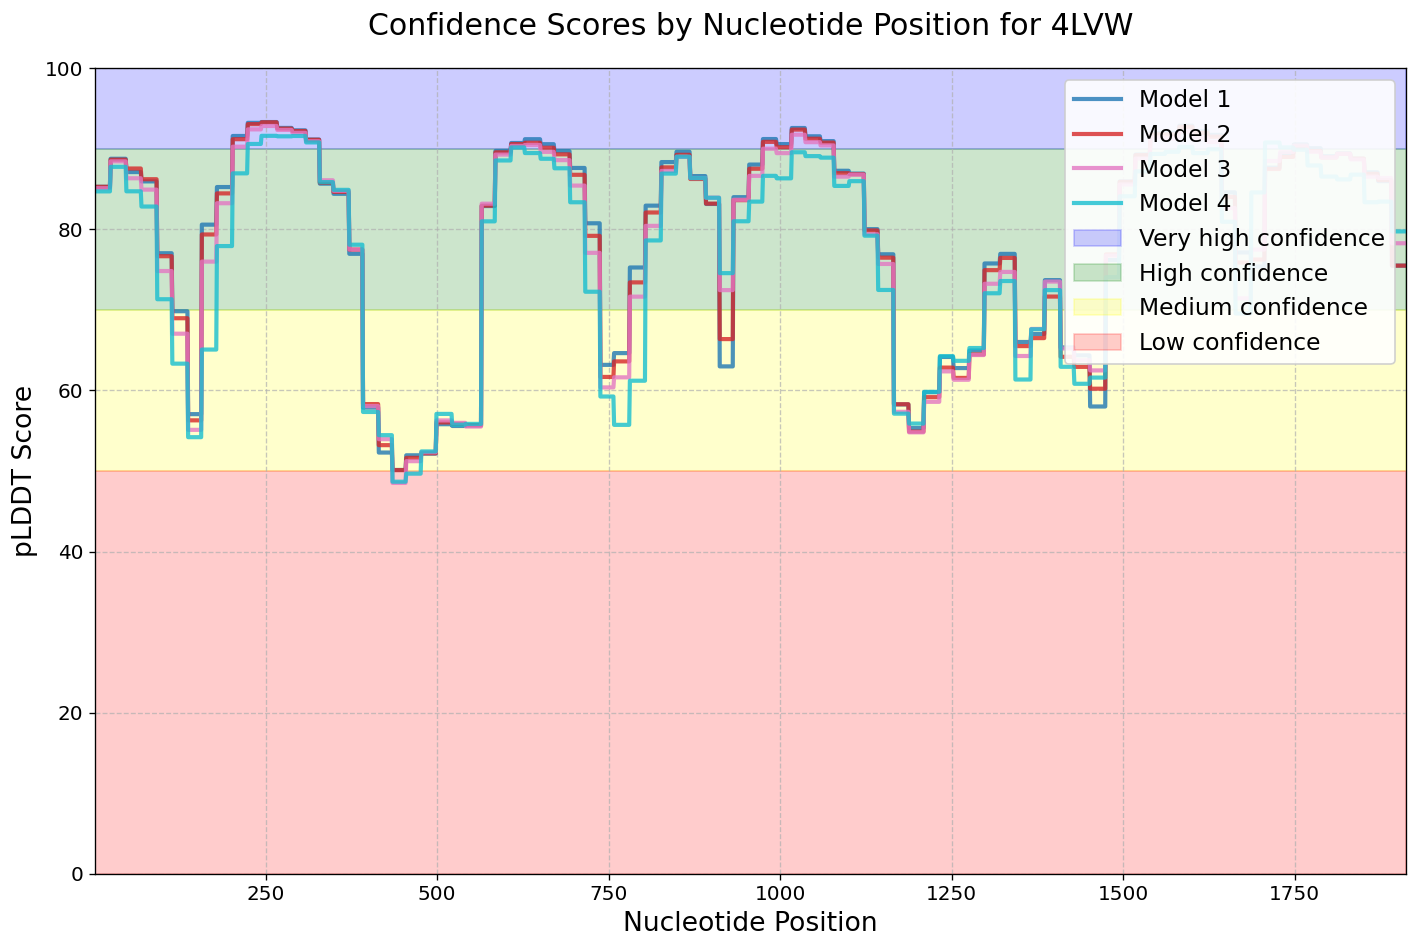

In [7]:
# @title Display Result
import os
import py3Dmol
from IPython.display import display, Markdown, Image
import matplotlib.pyplot as plt
import numpy as np

# Assuming output_path and fasta_filename are defined as shown previously
output_path = os.path.join(
    "/content/nufold_output", fasta_filename.replace(".fasta", "")
)
files = os.listdir(output_path)

# Filter for the PDB files with the specific prefix
pdb_files = [x for x in files if x.startswith(job_name) and x.endswith(".pdb")]
pdb_files.sort()  # Sort PDB files by name

# We'll only create one plot
plddt_plot_filename = f"{job_name}_plddt_plot.png"


# Function to get pLDDT scores from PDB file
def get_plddt_scores(pdb_file_path):
    plddt_scores = []
    with open(pdb_file_path) as f:
        for line in f:
            if line.startswith("ATOM"):
                try:
                    # pLDDT scores are stored in the B-factor column (positions 61-66)
                    plddt = float(line[60:66].strip())
                    plddt_scores.append(plddt)
                except ValueError:
                    continue
    return plddt_scores


# Function to visualize PDB file with py3Dmol with improved styling
def visualize_pdb_file(pdb_file_path, width=800, height=500):
    with open(pdb_file_path) as ifile:
        system = "".join([x for x in ifile])
    view = py3Dmol.view(width=width, height=height)
    view.addModelsAsFrames(system)

    # Apply improved styling with confidence coloring
    view.setStyle(
        {
            "cartoon": {
                "colorscheme": {"prop": "b", "gradient": "roygb", "min": 50, "max": 90},
                "thickness": 1.0,
                "opacity": 0.9,
            }
        }
    )

    # Set high-quality rendering
    view.setViewStyle({"style": "outline"})
    view.zoomTo()

    return view


# Function to create the pLDDT plot
def create_plddt_plot(pdb_files, output_dir, width=12, height=8, dpi=120):
    plt.figure(figsize=(width, height), dpi=dpi)

    # Define a colormap for the plot lines
    colors = plt.cm.tab10(np.linspace(0, 1, min(10, len(pdb_files))))

    for i, pdb_file in enumerate(pdb_files):
        pdb_path = os.path.join(output_dir, pdb_file)
        plddt_scores = get_plddt_scores(pdb_path)

        if plddt_scores:
            residue_indices = range(1, len(plddt_scores) + 1)
            plt.plot(
                residue_indices,
                plddt_scores,
                label=f"Model {i + 1}",
                color=colors[i],
                linewidth=2.5,
                alpha=0.8,
            )

    # Add confidence level regions with improved transparency
    plt.axhspan(90, 100, alpha=0.2, color="blue", label="Very high confidence")
    plt.axhspan(70, 90, alpha=0.2, color="green", label="High confidence")
    plt.axhspan(50, 70, alpha=0.2, color="yellow", label="Medium confidence")
    plt.axhspan(0, 50, alpha=0.2, color="red", label="Low confidence")

    plt.title(
        f"Confidence Scores by Nucleotide Position for {job_name}", fontsize=18, pad=20
    )
    plt.xlabel("Nucleotide Position", fontsize=16)
    plt.ylabel("pLDDT Score", fontsize=16)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="upper right", fontsize=14, framealpha=0.9)
    plt.tight_layout()

    # Add tick marks and ensure y-axis goes from 0 to 100
    plt.xlim(1, max(len(get_plddt_scores(os.path.join(output_dir, pdb_files[0]))), 1))
    plt.ylim(0, 100)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Save the plot with the standard filename
    plot_path = os.path.join(output_dir, plddt_plot_filename)
    plt.savefig(plot_path, dpi=dpi, bbox_inches="tight")
    return plot_path


# If there are PDB files, analyze and visualize them
if pdb_files:
    # Create the pLDDT plot only once
    plot_path = create_plddt_plot(pdb_files, output_path)

    display(Markdown(f"# 🧬 NuFold Structure Predictions for {job_name}"))

    # Display 3D models

    # @markdown **Color scheme represents confidence (pLDDT):**
    # @markdown - **Blue**: Very high confidence (90-100)
    # @markdown - **Green**: High confidence (70-90)
    # @markdown - **Yellow**: Medium confidence (50-70)
    # @markdown - **Orange/Red**: Low confidence (0-50)

    # Set the number of models to display (can be made adjustable)
    # @markdown Number of structures to display:
    num_structures = 1  # @param {"type":"raw","placeholder":"1"}
    num_structures = min(num_structures, len(pdb_files))

    for i, pdb_file in enumerate(pdb_files[:num_structures]):
        display(Markdown(f"### Model {i + 1}"))
        view = visualize_pdb_file(os.path.join(output_path, pdb_file))
        view.show()

    # Display pLDDT plot at the end
    display(Markdown("## 📈 Per-Nucleotide Confidence Plot"))
    # display(Image(plot_path))

else:
    display(Markdown("# ⚠️ No Results Found"))
    display(
        Markdown(
            "No PDB files were generated for your job. There might have been an error during processing."
        )
    )

# Code for downloading the ZIP file if needed
zipname = fasta_filename.replace(".fasta", "")
if download:
    import shutil
    from google.colab import files

    zip_filename = f"{zipname}.zip"
    shutil.make_archive(zip_filename.replace(".zip", ""), "zip", output_path)
    display(Markdown("## The download is probably going to take a while."))
    files.download(zip_filename)